In [1]:
%matplotlib inline

import anndata
import glob
import itertools
import matplotlib
from matplotlib import pyplot
import numpy
import os
import pandas
import rpy2
import scanpy as sc
import seaborn
import sys

%load_ext rpy2.ipython

print(f'Package versions:\nPython {sys.version}, anndata {anndata.__version__}, '
      f'matplotlib {matplotlib.__version__}, numpy {numpy.__version__}, pandas {pandas.__version__}, '
      f'rpy2 {rpy2.__version__}, scanpy {sc.__version__}, seaborn {seaborn.__version__}')

Package versions:
Python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0], anndata 0.7.5, matplotlib 3.4.2, numpy 1.21.0, pandas 1.1.5, rpy2 3.4.5, scanpy 1.8.1, seaborn 0.11.1


### Make AnnData

In [2]:
feature_counts = sorted(glob.glob('./*/*.featureCounts.csv'))
sample_names = [os.path.basename(os.path.dirname(elt)) for elt in feature_counts]

In [3]:
pandas.read_csv(feature_counts[0], sep='\t', comment='#').head()

,Geneid,Chr,Start,End,Strand,Length,./159/159_Aligned.sortedByCoord.out.prioritized.dedup.bam
0,ENSMUSG00000102693.1,chr1,3073253,3074322,+,1070,1
1,ENSMUSG00000064842.1,chr1,3102016,3102125,+,110,0
2,ENSMUSG00000051951.5,chr1;chr1;chr1;chr1;chr1;chr1;chr1,3205901;3206523;3213439;3213609;3214482;342170...,3207317;3207317;3215632;3216344;3216968;342190...,-;-;-;-;-;-;-,6094,221
3,ENSMUSG00000102851.1,chr1,3252757,3253236,+,480,0
4,ENSMUSG00000103377.1,chr1,3365731,3368549,-,2819,1


In [4]:
fc_dfs = []
for fc_path, sample_name in zip(feature_counts, sample_names):
    fc_df = pandas.read_csv(fc_path, sep='\t', comment='#')
    fc_df.columns = [elt if '/' not in elt else os.path.basename(os.path.dirname(elt)) for elt in fc_df.columns]
    fc_dfs.append(fc_df.set_index('Geneid')[sample_name])
fc_dfs[0]

Geneid
ENSMUSG00000102693.1        1
ENSMUSG00000064842.1        0
ENSMUSG00000051951.5      221
ENSMUSG00000102851.1        0
ENSMUSG00000103377.1        1
                        ...  
ENSMUSG00000064368.1     8912
ENSMUSG00000064369.1      112
ENSMUSG00000064370.1    49982
ENSMUSG00000064371.1        1
ENSMUSG00000064372.1     1233
Name: 159, Length: 55385, dtype: int64

In [5]:
counts_df = pandas.concat(fc_dfs, axis=1, keys=[elt.name for elt in fc_dfs])
print(counts_df.shape)
counts_df.head()

(55385, 48)


,159,160,161,162,163,164,165,166,167,170,...,207,208,210,211,212,213,214,215,217,218
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000102693.1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
ENSMUSG00000064842.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000051951.5,221,285,230,212,222,13,285,304,240,291,...,289,179,285,305,221,174,161,273,192,219
ENSMUSG00000102851.1,0,1,0,2,1,0,0,0,1,2,...,1,0,0,1,1,1,0,2,0,0
ENSMUSG00000103377.1,1,2,1,0,0,3,2,3,2,3,...,0,1,1,1,1,2,2,3,4,1


In [6]:
sample_metadata = pandas.read_csv('./sample_metadata.csv')
sample_metadata['exp_condition'] = sample_metadata['monomer_or_pff'] + '_' + sample_metadata['o2_status']
print(sample_metadata.shape)
sample_metadata.head()

(48, 8)


,sample_id,monomer_or_pff,o2_status,Injection date,DOB,DOD,batch,exp_condition
0,159,PFF,normoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_normoxia
1,160,PFF,normoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_normoxia
2,161,PFF,normoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_normoxia
3,162,PFF,normoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_normoxia
4,163,PFF,hypoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_hypoxia


In [7]:
gene_metadata = pandas.read_csv('../ref_data/ensembl_id_to_gene_name.tab', sep='\t', 
                                names=['Geneid', 'common_name'])
gene_metadata = gene_metadata.join(fc_df[['Geneid', 'Length']].set_index('Geneid'), on='Geneid')
print(gene_metadata.shape)
gene_metadata.head()

(55385, 3)


,Geneid,common_name,Length
0,ENSMUSG00000000001.4,Gnai3,3262
1,ENSMUSG00000000003.15,Pbsn,902
2,ENSMUSG00000000028.15,Cdc45,3506
3,ENSMUSG00000000031.16,H19,2460
4,ENSMUSG00000000037.17,Scml2,6397


In [8]:
anndata_obj =  anndata.AnnData(X=counts_df.T, obs=sample_metadata.set_index('sample_id').loc[counts_df.T.index.astype(int)], 
                               var=gene_metadata.set_index('Geneid').loc[counts_df.T.columns])
anndata_obj.layers['raw_counts'] = anndata_obj.X.copy()
print(anndata_obj)
anndata_obj.obs.head()

AnnData object with n_obs × n_vars = 48 × 55385
    obs: 'monomer_or_pff', 'o2_status', 'Injection date', 'DOB', 'DOD', 'batch', 'exp_condition'
    var: 'common_name', 'Length'
    layers: 'raw_counts'


/broad/moothalab/sandbox/tdurham/anaconda/envs/sc_remake2/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,monomer_or_pff,o2_status,Injection date,DOB,DOD,batch,exp_condition
159,PFF,normoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_normoxia
160,PFF,normoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_normoxia
161,PFF,normoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_normoxia
162,PFF,normoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_normoxia
163,PFF,hypoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_hypoxia


### Remove sample 164, which had low input, low numbers of aligned reads, and is an outlier in the analysis

In [9]:
anndata_obj = anndata_obj[anndata_obj.obs.index.values != '164']
print(anndata_obj)

View of AnnData object with n_obs × n_vars = 47 × 55385
    obs: 'monomer_or_pff', 'o2_status', 'Injection date', 'DOB', 'DOD', 'batch', 'exp_condition'
    var: 'common_name', 'Length'
    layers: 'raw_counts'


### Analyze counts

/broad/moothalab/sandbox/tdurham/anaconda/envs/sc_remake2/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


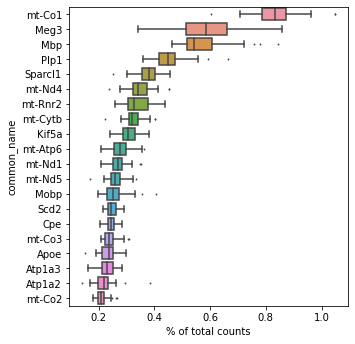

In [10]:
sc.pl.highest_expr_genes(anndata_obj, n_top=20, gene_symbols='common_name')

... storing 'monomer_or_pff' as categorical
... storing 'o2_status' as categorical
... storing 'Injection date' as categorical
... storing 'DOB' as categorical
... storing 'DOD' as categorical
... storing 'exp_condition' as categorical
... storing 'common_name' as categorical


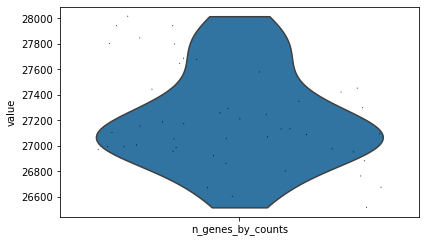

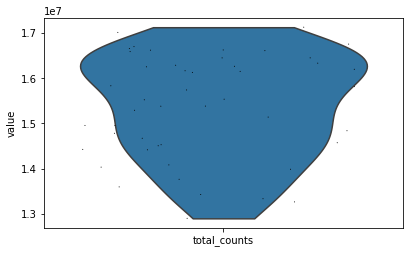

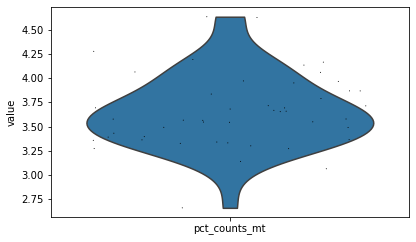

In [11]:
anndata_obj.var['mt'] = anndata_obj.var['common_name'].str.startswith('mt-')
sc.pp.calculate_qc_metrics(anndata_obj, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(anndata_obj, ['n_genes_by_counts'], jitter=0.4, multi_panel=False)
sc.pl.violin(anndata_obj, ['total_counts'], jitter=0.4, multi_panel=False)
sc.pl.violin(anndata_obj, ['pct_counts_mt'], jitter=0.4, multi_panel=False)

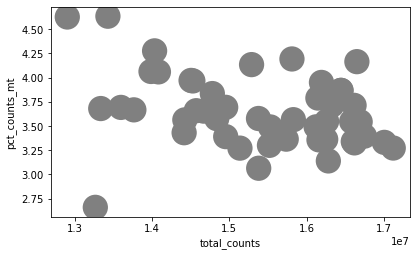

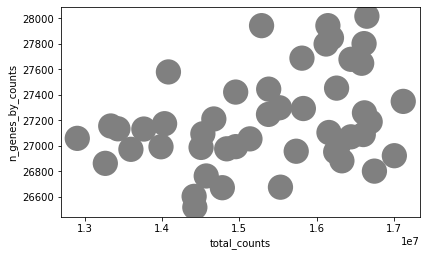

In [12]:
sc.pl.scatter(anndata_obj, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(anndata_obj, x='total_counts', y='n_genes_by_counts')

In [13]:
sc.pp.normalize_total(anndata_obj, target_sum=1e6)
sc.pp.log1p(anndata_obj)
anndata_obj.layers['normlog_counts'] = anndata_obj.X.copy()

In [14]:
sc.pp.scale(anndata_obj, max_value=10)
anndata_obj.layers['normlog_scaled_counts'] = anndata_obj.X.copy()
anndata_obj.X = anndata_obj.layers['raw_counts']
print(anndata_obj)

AnnData object with n_obs × n_vars = 47 × 55385
    obs: 'monomer_or_pff', 'o2_status', 'Injection date', 'DOB', 'DOD', 'batch', 'exp_condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'common_name', 'Length', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'raw_counts', 'normlog_counts', 'normlog_scaled_counts'


## Do TPM normalization

In [15]:
# got this function from here: https://gist.github.com/slowkow/c6ab0348747f86e2748b
# Looks correct. This is a good explanation of RPKM vs TPM: https://btep.ccr.cancer.gov/question/faq/what-is-the-difference-between-rpkm-fpkm-and-tpm/
def read_counts2tpm(anndata_obj, gene_lens='Length', raw_counts_layer='raw_counts'):
    """
    convert read counts to TPM (transcripts per million)
    :param df: a dataFrame containing read counts from each gene (rows) and each sample (columns)
    :param sample_names: list or array of sample names
    :param gene_lens: series of gene or transcript lengths
    :return: TPM
    """
    sample_reads = anndata_obj.layers[raw_counts_layer].copy()
    if isinstance(gene_lens, str):
        gene_lens = anndata_obj.var[gene_lens].to_numpy()
    elif len(gene_lens) != anndata_obj.shape[1]:
        raise Exception('The value of gene_lens must be either the name of the anndata_obj.var column '
                        'that contains the transcript lengths or an iterable specifying '
                        'length values for each gene.')
    rate = sample_reads / gene_lens
    tpm = (rate.T / numpy.sum(rate, axis=1)).T * 1e6
    return numpy.nan_to_num(tpm)
#    return pandas.DataFrame(data=tpm, columns=sample_name)

In [16]:
anndata_obj.X = read_counts2tpm(anndata_obj)
anndata_obj.layers['tpm_counts'] = anndata_obj.X.copy()
print(anndata_obj)

AnnData object with n_obs × n_vars = 47 × 55385
    obs: 'monomer_or_pff', 'o2_status', 'Injection date', 'DOB', 'DOD', 'batch', 'exp_condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'common_name', 'Length', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'raw_counts', 'normlog_counts', 'normlog_scaled_counts', 'tpm_counts'


In [17]:
sc.pp.log1p(anndata_obj)
anndata_obj.layers['logtpm_counts'] = anndata_obj.X.copy()
anndata_obj.X

array([[0.21460754, 0.        , 2.3310424 , ..., 9.32291305, 1.57336727,
        8.45841666],
       [0.        , 0.        , 2.50667921, ..., 9.33840238, 1.52493591,
        8.51460097],
       [0.        , 0.        , 2.37063914, ..., 9.31931406, 0.        ,
        8.55586096],
       ...,
       [0.        , 0.        , 2.4056047 , ..., 9.18707923, 2.87921429,
        8.46493092],
       [0.        , 0.        , 2.08875159, ..., 9.20603703, 2.04161606,
        8.38895049],
       [0.        , 0.        , 2.26329789, ..., 9.2119326 , 0.        ,
        8.35081601]])

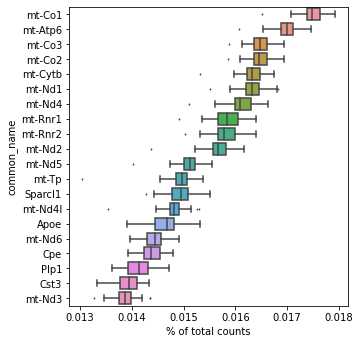

In [18]:
sc.pl.highest_expr_genes(anndata_obj, n_top=20, gene_symbols='common_name')

## Filter for just protein-coding genes

In [19]:
gene_info = pandas.read_csv('../ref_data/lncRNAs_and_prot_coding_genes.csv',
                            sep=',', index_col=0)
print(gene_info.shape)
gene_info.head()

(31815, 3)


,gene_name,gene_type,gene_name_type
gene_id,,,
ENSMUSG00000101796.1,Gm29277,lncRNA,Gm*
ENSMUSG00000101492.1,Gm29089,lncRNA,Gm*
ENSMUSG00000101036.1,Gm28588,lncRNA,Gm*
ENSMUSG00000101107.1,Gm28587,lncRNA,Gm*
ENSMUSG00000099876.1,Gm29650,lncRNA,Gm*


In [20]:
anndata_total = anndata_obj.copy()
anndata_obj = anndata_obj[:,gene_info[gene_info['gene_type'] == 'protein_coding'].index.values]
print(anndata_obj)

View of AnnData object with n_obs × n_vars = 47 × 21856
    obs: 'monomer_or_pff', 'o2_status', 'Injection date', 'DOB', 'DOD', 'batch', 'exp_condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'common_name', 'Length', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'raw_counts', 'normlog_counts', 'normlog_scaled_counts', 'tpm_counts', 'logtpm_counts'


Trying to set attribute `.obs` of view, copying.


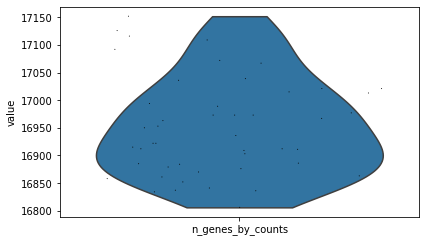

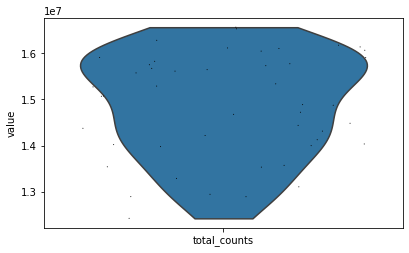

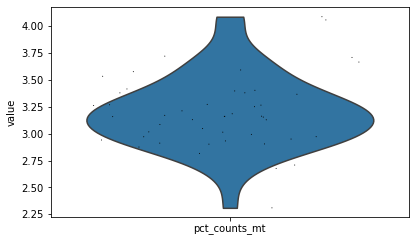

In [21]:
anndata_obj.X = anndata_obj.layers['raw_counts'].copy()
sc.pp.calculate_qc_metrics(anndata_obj, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(anndata_obj, ['n_genes_by_counts'], jitter=0.4, multi_panel=False)
sc.pl.violin(anndata_obj, ['total_counts'], jitter=0.4, multi_panel=False)
sc.pl.violin(anndata_obj, ['pct_counts_mt'], jitter=0.4, multi_panel=False)

In [22]:
anndata_obj.obs[['n_genes_by_counts', 'total_counts', 'pct_counts_mt']].mean(axis=0)

n_genes_by_counts    1.695109e+04
total_counts         1.486680e+07
pct_counts_mt        3.196112e+00
dtype: float64

## Select genes for PCA

In [23]:
anndata_obj.X = anndata_obj.layers['logtpm_counts'].copy()

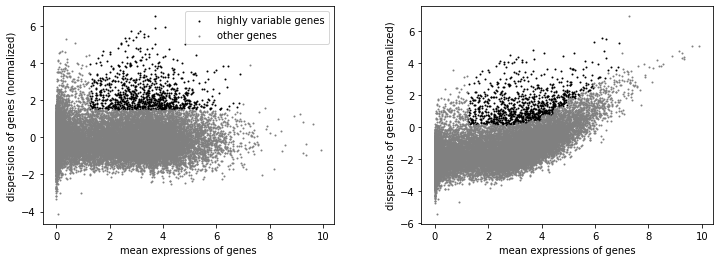

Found 949 highly variable genes.


In [24]:
min_mean = 1.25
max_mean = 7
min_disp = 1.5

sc.pp.highly_variable_genes(anndata_obj, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)
sc.pl.highly_variable_genes(anndata_obj)
print('Found {!s} highly variable genes.'.format(anndata_obj.var['highly_variable'].sum()))

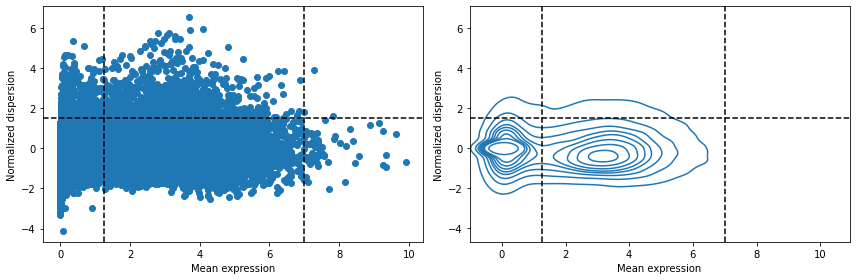

In [25]:
min_mean = 1.25
max_mean = 7
min_disp = 1.5

fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].scatter(anndata_obj.var['means'], anndata_obj.var['dispersions_norm'])
#min_mean=0.5
axes[0].axvline(min_mean, linestyle='--', color='k')
#max_mean=6
axes[0].axvline(max_mean, linestyle='--', color='k')
#min_disp=1.0
axes[0].axhline(min_disp, linestyle='--', color='k')
#axes.scatter(anndata_obj.var.loc[anndata_obj.var['common_name'] == 'Ercc1', 'means'],
#             anndata_obj.var.loc[anndata_obj.var['common_name'] == 'Ercc1', 'dispersions_norm'],
#             color='r', label='Ercc1')
axes[0].set_xlabel('Mean expression')
axes[0].set_ylabel('Normalized dispersion')

seaborn.kdeplot(x=anndata_obj.var['means'], y=anndata_obj.var['dispersions_norm'], ax=axes[1])
#min_mean=0.5
axes[1].axvline(min_mean, linestyle='--', color='k')
#max_mean=6
axes[1].axvline(max_mean, linestyle='--', color='k')
#min_disp=1.0
axes[1].axhline(min_disp, linestyle='--', color='k')
#axes.scatter(anndata_obj.var.loc[anndata_obj.var['common_name'] == 'Ercc1', 'means'],
#             anndata_obj.var.loc[anndata_obj.var['common_name'] == 'Ercc1', 'dispersions_norm'],
#             color='r', label='Ercc1')
axes[1].set_xlabel('Mean expression')
axes[1].set_ylabel('Normalized dispersion')

#axes.legend(bbox_to_anchor=[1,1])
fig.tight_layout()

In [26]:
sc.pp.scale(anndata_obj, max_value=10)
anndata_obj.layers['logtpm_scaled_counts'] = anndata_obj.X

In [27]:
sc.tl.pca(anndata_obj, n_comps=46, svd_solver='arpack')

In [28]:
anndata_obj.obs['mouse_id'] = 'm' + anndata_obj.obs.index
anndata_obj.obs['mouse_id'] = anndata_obj.obs['mouse_id'].astype('category')
anndata_obj.obs.head()

,monomer_or_pff,o2_status,Injection date,DOB,DOD,batch,exp_condition,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,mouse_id
159,PFF,normoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_normoxia,16973,13533468.0,503320.0,3.719076,m159
160,PFF,normoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_normoxia,17152,14720930.0,528591.0,3.590745,m160
161,PFF,normoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_normoxia,16977,13572026.0,479388.0,3.532177,m161
162,PFF,normoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_normoxia,16876,12945997.0,525013.0,4.055408,m162
163,PFF,hypoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_hypoxia,16861,12425746.0,507629.0,4.085300,m163


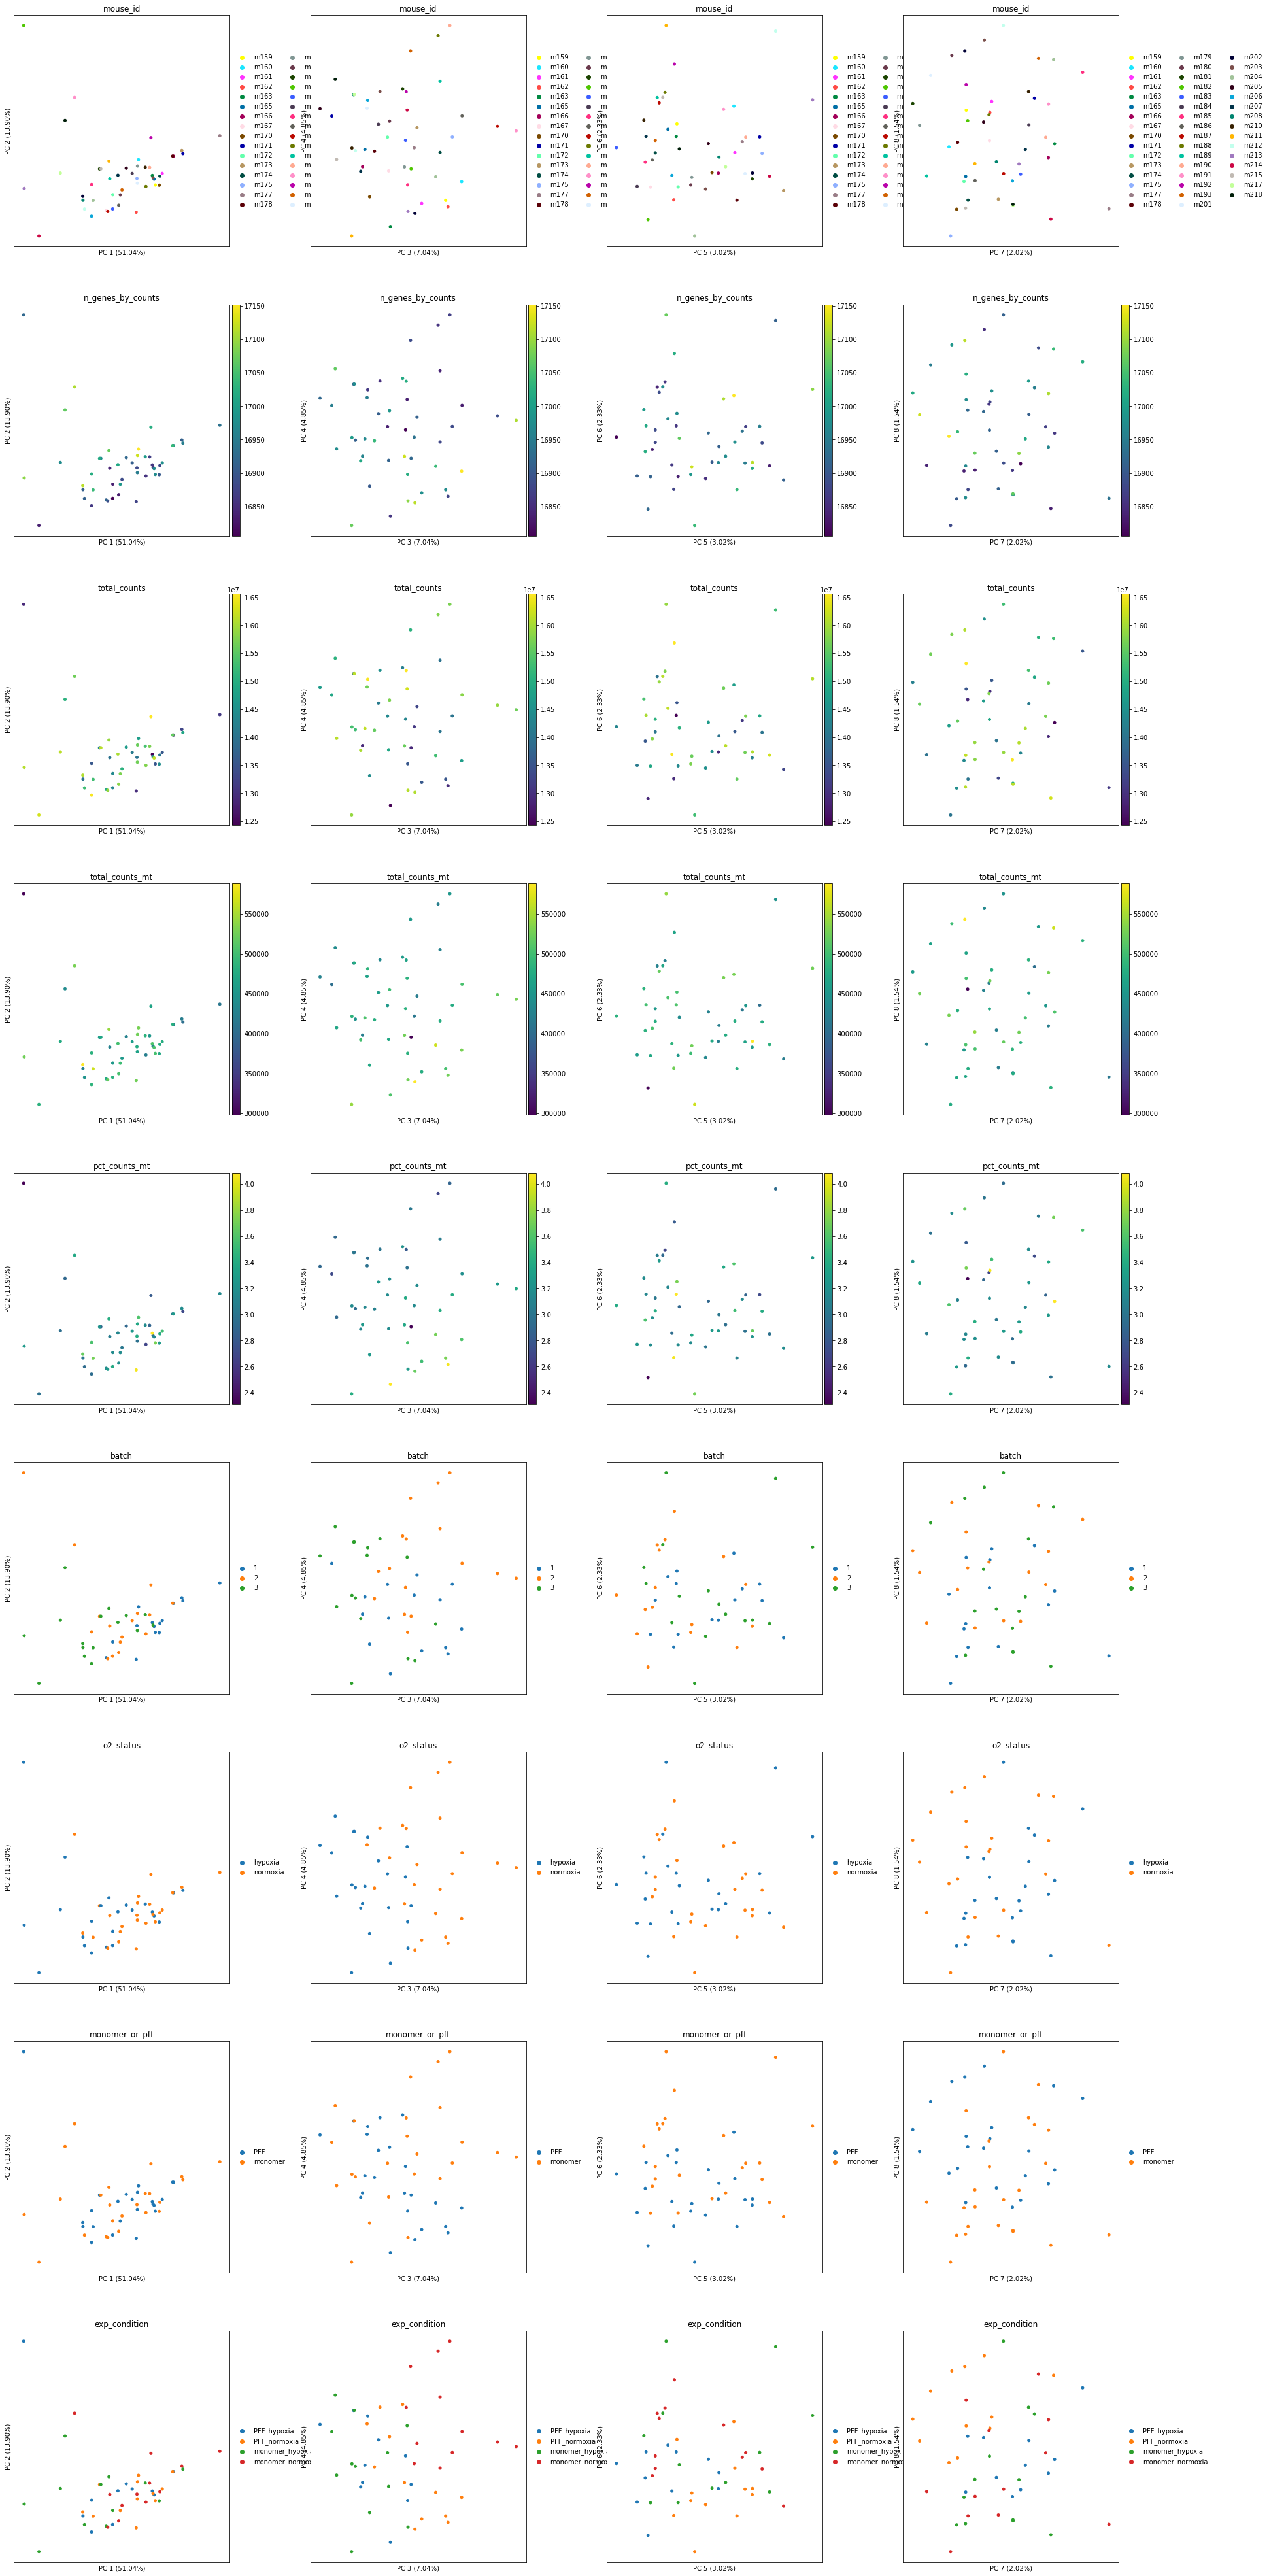

In [29]:
anndata_obj.obs['o2_status'] = anndata_obj.obs['o2_status'].astype('category')
anndata_obj.obs['batch'] = anndata_obj.obs['batch'].astype('category')

ncols=4
nrows=7
with matplotlib.rc_context({'figure.figsize':(1.5*ncols, (1.5*(2/3))*nrows)}):
    fig = sc.pl.pca(anndata_obj, color=['mouse_id', 'n_genes_by_counts', 'total_counts', 
                                        'total_counts_mt', 'pct_counts_mt', 'batch', 'o2_status', 
                                        'monomer_or_pff', 'exp_condition'], 
                    s=100, components=['1,2','3,4','5,6','7,8'], wspace=0.25, ncols=ncols, return_fig=True)
    for ax in fig.axes:
        #the colorbar axes are labeled with '<colorbar>' text, but data axes are not
        if ax.get_label():
            continue
        x_pc = int(ax.get_xlabel()[-1]) - 1
        ax.set_xlabel('PC {!s} ({:.2f}%)'.format(x_pc+1, anndata_obj.uns['pca']['variance_ratio'][x_pc] * 100))
    
        y_pc = int(ax.get_ylabel()[-1]) - 1
        ax.set_ylabel('PC {!s} ({:.2f}%)'.format(y_pc+1, anndata_obj.uns['pca']['variance_ratio'][y_pc] * 100))

    fig.show()

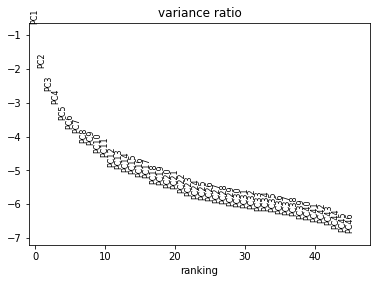

In [30]:
sc.pl.pca_variance_ratio(anndata_obj, n_pcs=47, log=True)

## Attempt a batch correction with ComBat-seq, but remove outliers first

In [31]:
outlier_samples = ['m182', 'm218', 'm191', 'm213', 'm214']

In [32]:
numpy.sum(anndata_obj.layers['raw_counts'].sum(axis=0) == 0)

2255

In [33]:
#remove genes that have zero counts in our data
anndata_obj = anndata_obj[:,anndata_obj.layers['raw_counts'].sum(axis=0) > 0]

#remove outlier samples
anndata_obj = anndata_obj[~anndata_obj.obs['mouse_id'].isin(outlier_samples)]

anndata_obj

View of AnnData object with n_obs × n_vars = 42 × 19601
    obs: 'monomer_or_pff', 'o2_status', 'Injection date', 'DOB', 'DOD', 'batch', 'exp_condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mouse_id'
    var: 'common_name', 'Length', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'mouse_id_colors', 'batch_colors', 'o2_status_colors', 'monomer_or_pff_colors', 'exp_condition_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'normlog_counts', 'normlog_scaled_counts', 'tpm_counts', 'logtpm_counts', 'logtpm_scaled_counts'

In [34]:
raw_counts_mat = anndata_obj.layers['raw_counts'].copy().T
batch_indicator = anndata_obj.obs['batch'].astype(str)
covariates = anndata_obj.obs['exp_condition'].astype(str)

In [35]:
%%R -i raw_counts_mat -i batch_indicator -i covariates -o adjusted_counts

library('sva')

raw_counts_mat <- as.matrix(raw_counts_mat)
adjusted_counts <- ComBat_seq(raw_counts_mat, batch=batch_indicator, group=covariates)

dim(adjusted_counts)

R[write to console]: Loading required package: mgcv

R[write to console]: Loading required package: nlme

R[write to console]: This is mgcv 1.8-36. For overview type 'help("mgcv-package")'.

R[write to console]: Loading required package: genefilter

R[write to console]: Loading required package: BiocParallel



Found 3 batches
Using full model in ComBat-seq.
Adjusting for 3 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data
[1] 19601    42


In [36]:
anndata_obj.layers['raw_counts_bc'] = adjusted_counts.T.copy()
anndata_obj.X = anndata_obj.layers['raw_counts_bc'].copy()

In [37]:
anndata_obj.X = read_counts2tpm(anndata_obj, raw_counts_layer='raw_counts_bc')
anndata_obj.layers['tpm_counts_bc'] = anndata_obj.X.copy()
print(anndata_obj)

AnnData object with n_obs × n_vars = 42 × 19601
    obs: 'monomer_or_pff', 'o2_status', 'Injection date', 'DOB', 'DOD', 'batch', 'exp_condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mouse_id'
    var: 'common_name', 'Length', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'mouse_id_colors', 'batch_colors', 'o2_status_colors', 'monomer_or_pff_colors', 'exp_condition_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'normlog_counts', 'normlog_scaled_counts', 'tpm_counts', 'logtpm_counts', 'logtpm_scaled_counts', 'raw_counts_bc', 'tpm_counts_bc'


In [38]:
sc.pp.log1p(anndata_obj)
anndata_obj.layers['logtpm_counts_bc'] = anndata_obj.X.copy()
anndata_obj.X

array([[0.        , 0.35747127, 0.        , ..., 1.85188969, 2.51170029,
        0.45986918],
       [0.15812519, 0.34414441, 0.        , ..., 1.80251688, 2.78782614,
        0.48477784],
       [0.        , 0.83177951, 0.        , ..., 1.76659308, 2.57720387,
        0.46223264],
       ...,
       [0.        , 0.        , 0.12591403, ..., 1.63064812, 2.55133591,
        0.34018418],
       [0.        , 0.55802423, 0.12093481, ..., 1.89163808, 2.60290495,
        0.55763036],
       [0.        , 0.        , 0.        , ..., 1.74970861, 2.61237313,
        0.48569203]])

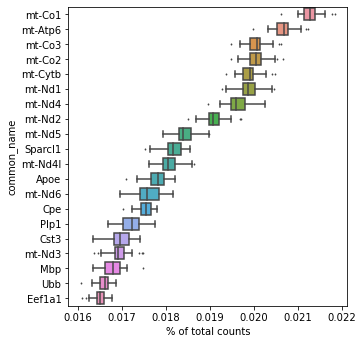

In [39]:
sc.pl.highest_expr_genes(anndata_obj, n_top=20, gene_symbols='common_name')

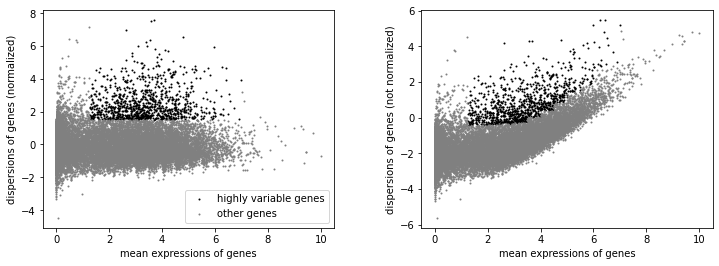

Found 974 highly variable genes.


In [40]:
min_mean = 1.25
max_mean = 7
min_disp = 1.5

sc.pp.highly_variable_genes(anndata_obj, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)
sc.pl.highly_variable_genes(anndata_obj)
print('Found {!s} highly variable genes.'.format(anndata_obj.var['highly_variable'].sum()))

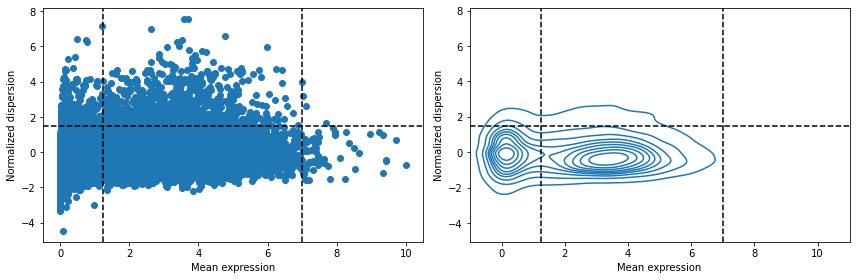

In [41]:
min_mean = 1.25
max_mean = 7
min_disp = 1.5

fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].scatter(anndata_obj.var['means'], anndata_obj.var['dispersions_norm'])
#min_mean=0.5
axes[0].axvline(min_mean, linestyle='--', color='k')
#max_mean=6
axes[0].axvline(max_mean, linestyle='--', color='k')
#min_disp=1.0
axes[0].axhline(min_disp, linestyle='--', color='k')
#axes.scatter(anndata_obj.var.loc[anndata_obj.var['common_name'] == 'Ercc1', 'means'],
#             anndata_obj.var.loc[anndata_obj.var['common_name'] == 'Ercc1', 'dispersions_norm'],
#             color='r', label='Ercc1')
axes[0].set_xlabel('Mean expression')
axes[0].set_ylabel('Normalized dispersion')

seaborn.kdeplot(x=anndata_obj.var['means'], y=anndata_obj.var['dispersions_norm'], ax=axes[1])
#min_mean=0.5
axes[1].axvline(min_mean, linestyle='--', color='k')
#max_mean=6
axes[1].axvline(max_mean, linestyle='--', color='k')
#min_disp=1.0
axes[1].axhline(min_disp, linestyle='--', color='k')
#axes.scatter(anndata_obj.var.loc[anndata_obj.var['common_name'] == 'Ercc1', 'means'],
#             anndata_obj.var.loc[anndata_obj.var['common_name'] == 'Ercc1', 'dispersions_norm'],
#             color='r', label='Ercc1')
axes[1].set_xlabel('Mean expression')
axes[1].set_ylabel('Normalized dispersion')

#axes.legend(bbox_to_anchor=[1,1])
fig.tight_layout()

In [42]:
anndata_obj.var['expressed'] = anndata_obj.var['means'] > min_mean

In [43]:
sc.pp.scale(anndata_obj, max_value=10)
anndata_obj.layers['logtpm_scaled_counts_bc'] = anndata_obj.X

In [44]:
sc.tl.pca(anndata_obj, n_comps=41, svd_solver='arpack')

In [45]:
anndata_obj.obs['mouse_id'] = 'm' + anndata_obj.obs.index
anndata_obj.obs['mouse_id'] = anndata_obj.obs['mouse_id'].astype('category')
anndata_obj.obs.head()

,monomer_or_pff,o2_status,Injection date,DOB,DOD,batch,exp_condition,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,mouse_id
159,PFF,normoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_normoxia,16973,13533468.0,503320.0,3.719076,m159
160,PFF,normoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_normoxia,17152,14720930.0,528591.0,3.590745,m160
161,PFF,normoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_normoxia,16977,13572026.0,479388.0,3.532177,m161
162,PFF,normoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_normoxia,16876,12945997.0,525013.0,4.055408,m162
163,PFF,hypoxia,4/7/2022,12/7/2021,7/7/2022,1,PFF_hypoxia,16861,12425746.0,507629.0,4.085300,m163


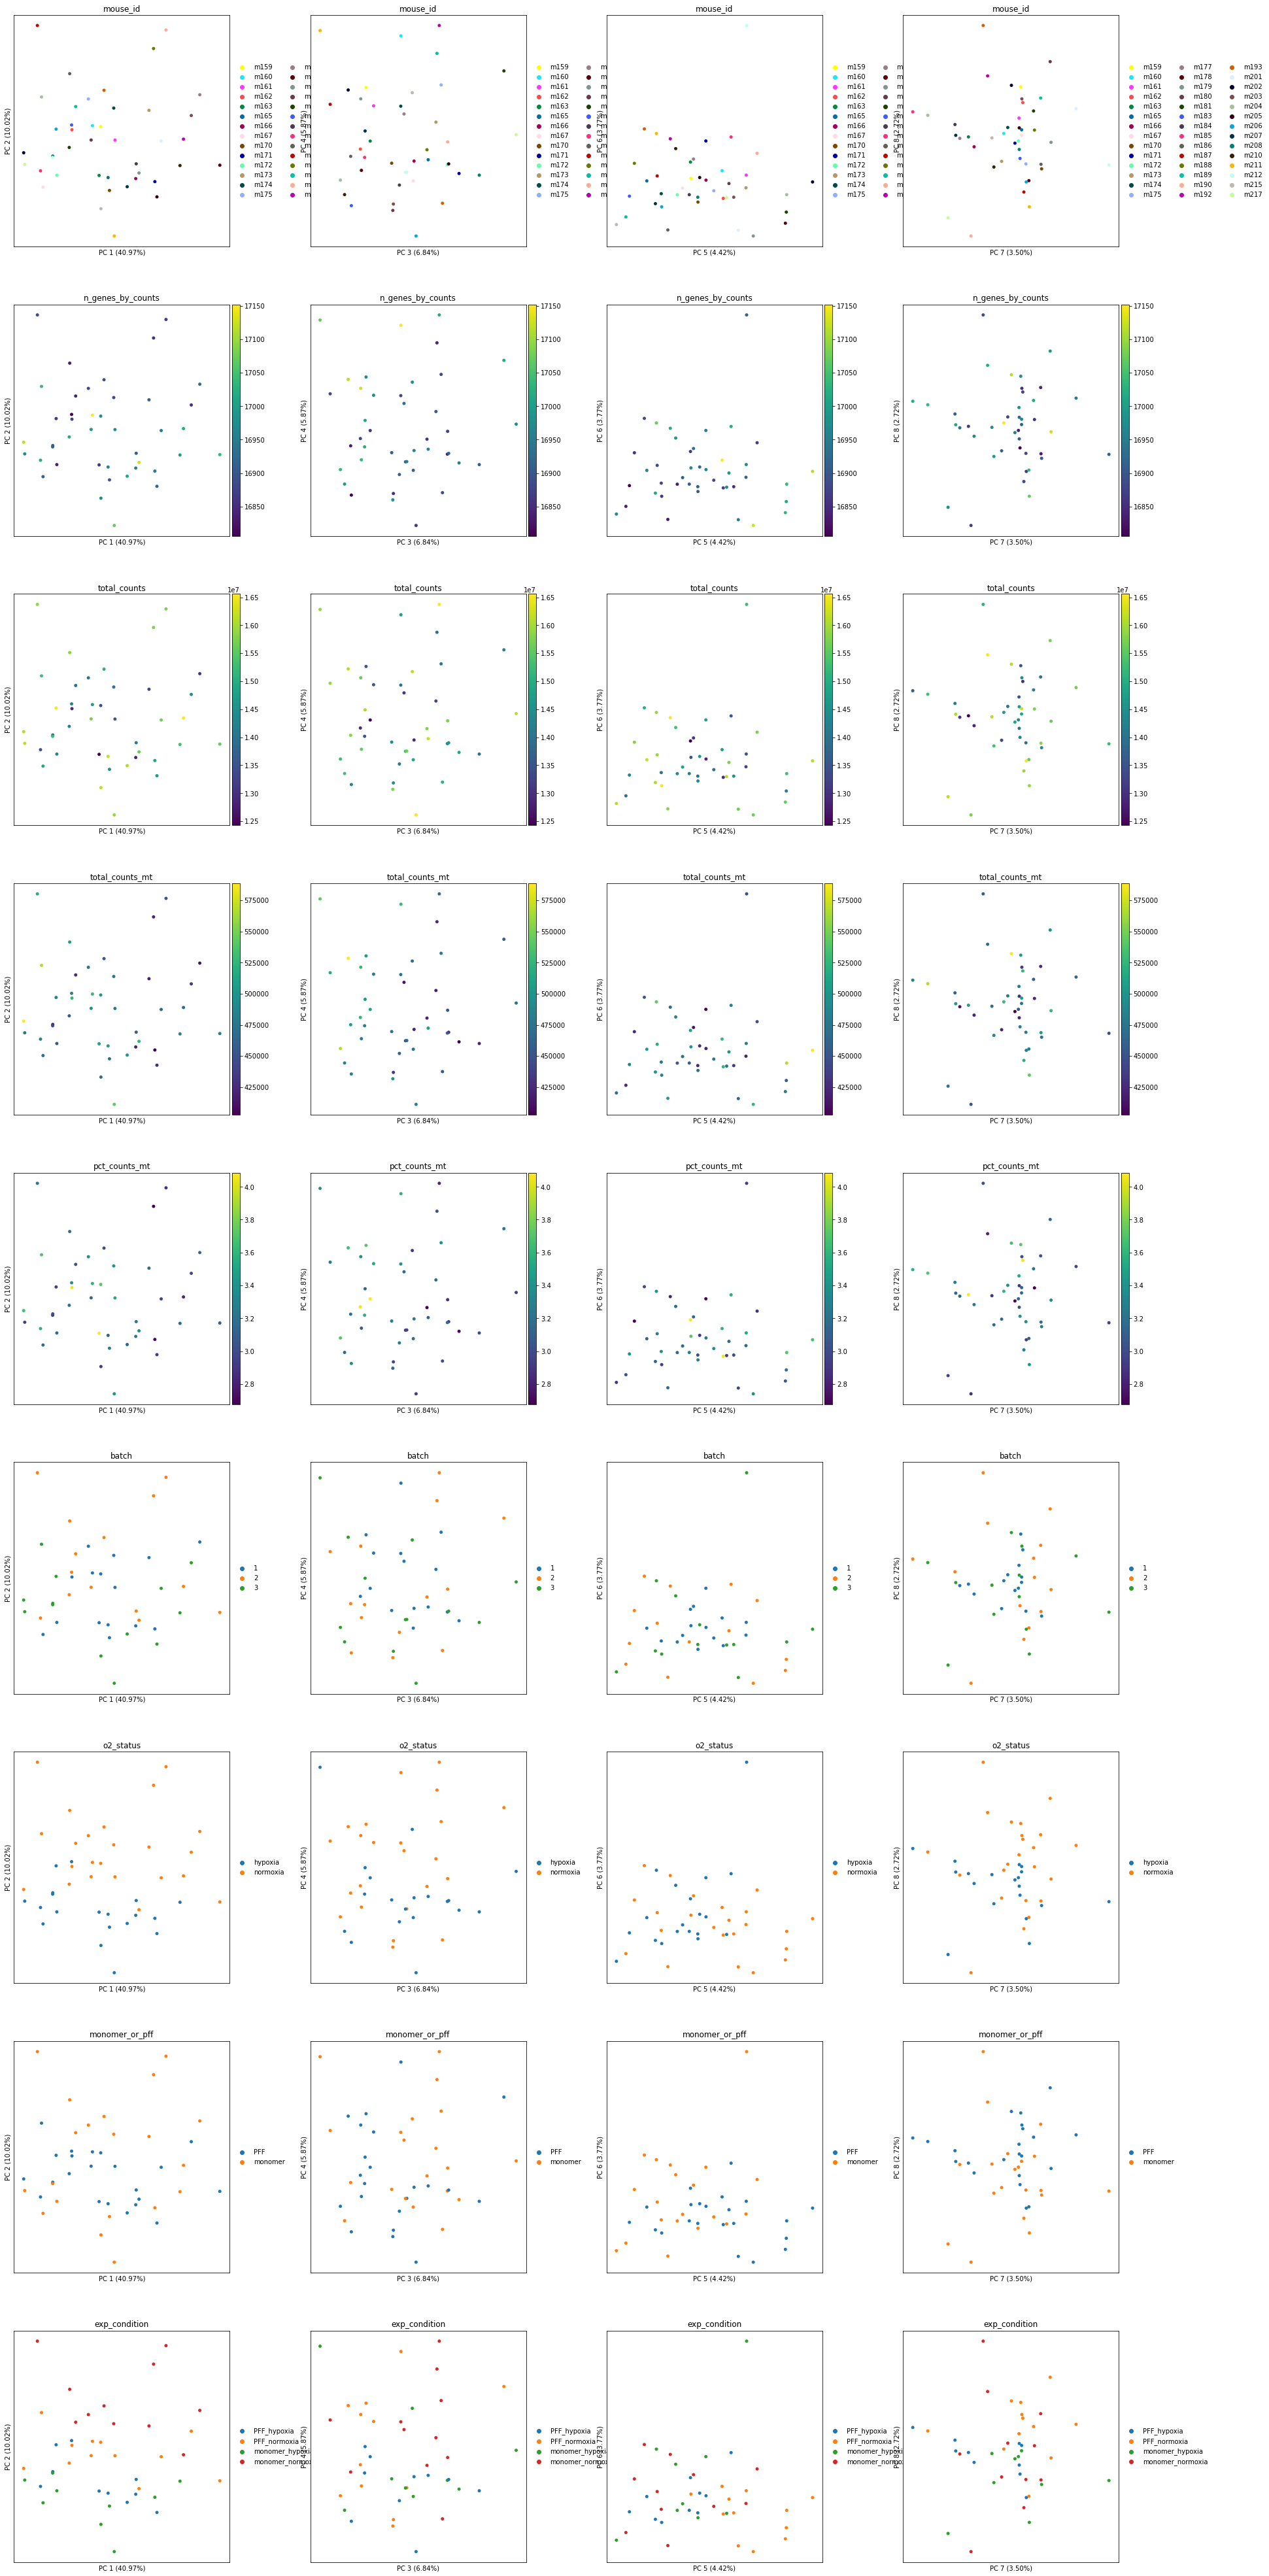

In [46]:
anndata_obj.obs['o2_status'] = anndata_obj.obs['o2_status'].astype('category')
anndata_obj.obs['batch'] = anndata_obj.obs['batch'].astype('category')

ncols=4
nrows=7
with matplotlib.rc_context({'figure.figsize':(1.5*ncols, (1.5*(2/3))*nrows)}):
    fig = sc.pl.pca(anndata_obj, color=['mouse_id', 'n_genes_by_counts', 'total_counts', 
                                        'total_counts_mt', 'pct_counts_mt', 'batch', 'o2_status', 
                                        'monomer_or_pff', 'exp_condition'], 
                    s=100, components=['1,2','3,4','5,6','7,8'], wspace=0.25, ncols=ncols, return_fig=True)
    for ax in fig.axes:
        #the colorbar axes are labeled with '<colorbar>' text, but data axes are not
        if ax.get_label():
            continue
        x_pc = int(ax.get_xlabel()[-1]) - 1
        ax.set_xlabel('PC {!s} ({:.2f}%)'.format(x_pc+1, anndata_obj.uns['pca']['variance_ratio'][x_pc] * 100))
    
        y_pc = int(ax.get_ylabel()[-1]) - 1
        ax.set_ylabel('PC {!s} ({:.2f}%)'.format(y_pc+1, anndata_obj.uns['pca']['variance_ratio'][y_pc] * 100))

    fig.show()

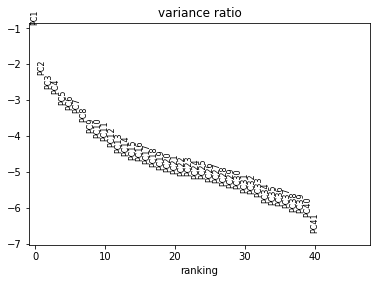

In [47]:
sc.pl.pca_variance_ratio(anndata_obj, n_pcs=47, log=True)

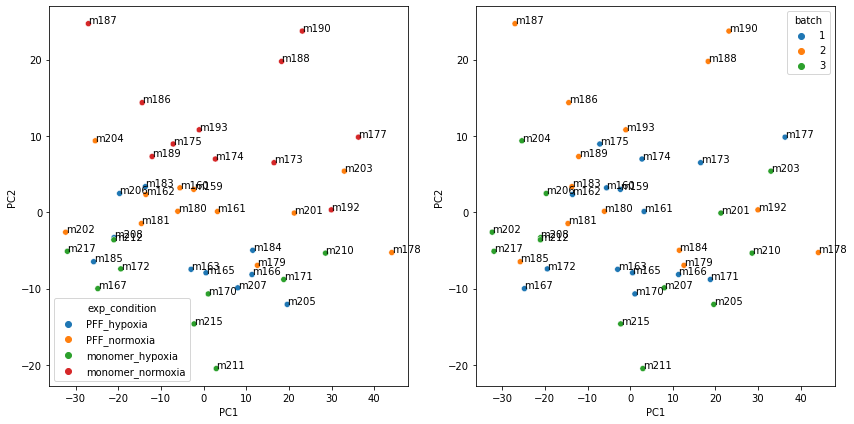

In [48]:
to_plot = anndata_obj.obs.copy()
to_plot[['PC1', 'PC2']] = anndata_obj.obsm['X_pca'][:,:2]

fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(12,6))
seaborn.scatterplot(data=to_plot, x='PC1', y='PC2', hue='exp_condition', ax=axes[0])
for mname, pcx, pcy in to_plot[['mouse_id', 'PC1', 'PC2']].to_numpy():
    axes[0].annotate(mname, (pcx, pcy))

seaborn.scatterplot(data=to_plot, x='PC1', y='PC2', hue='batch', ax=axes[1])
for mname, pcx, pcy in to_plot[['mouse_id', 'PC1', 'PC2']].to_numpy():
    axes[1].annotate(mname, (pcx, pcy))
fig.tight_layout()

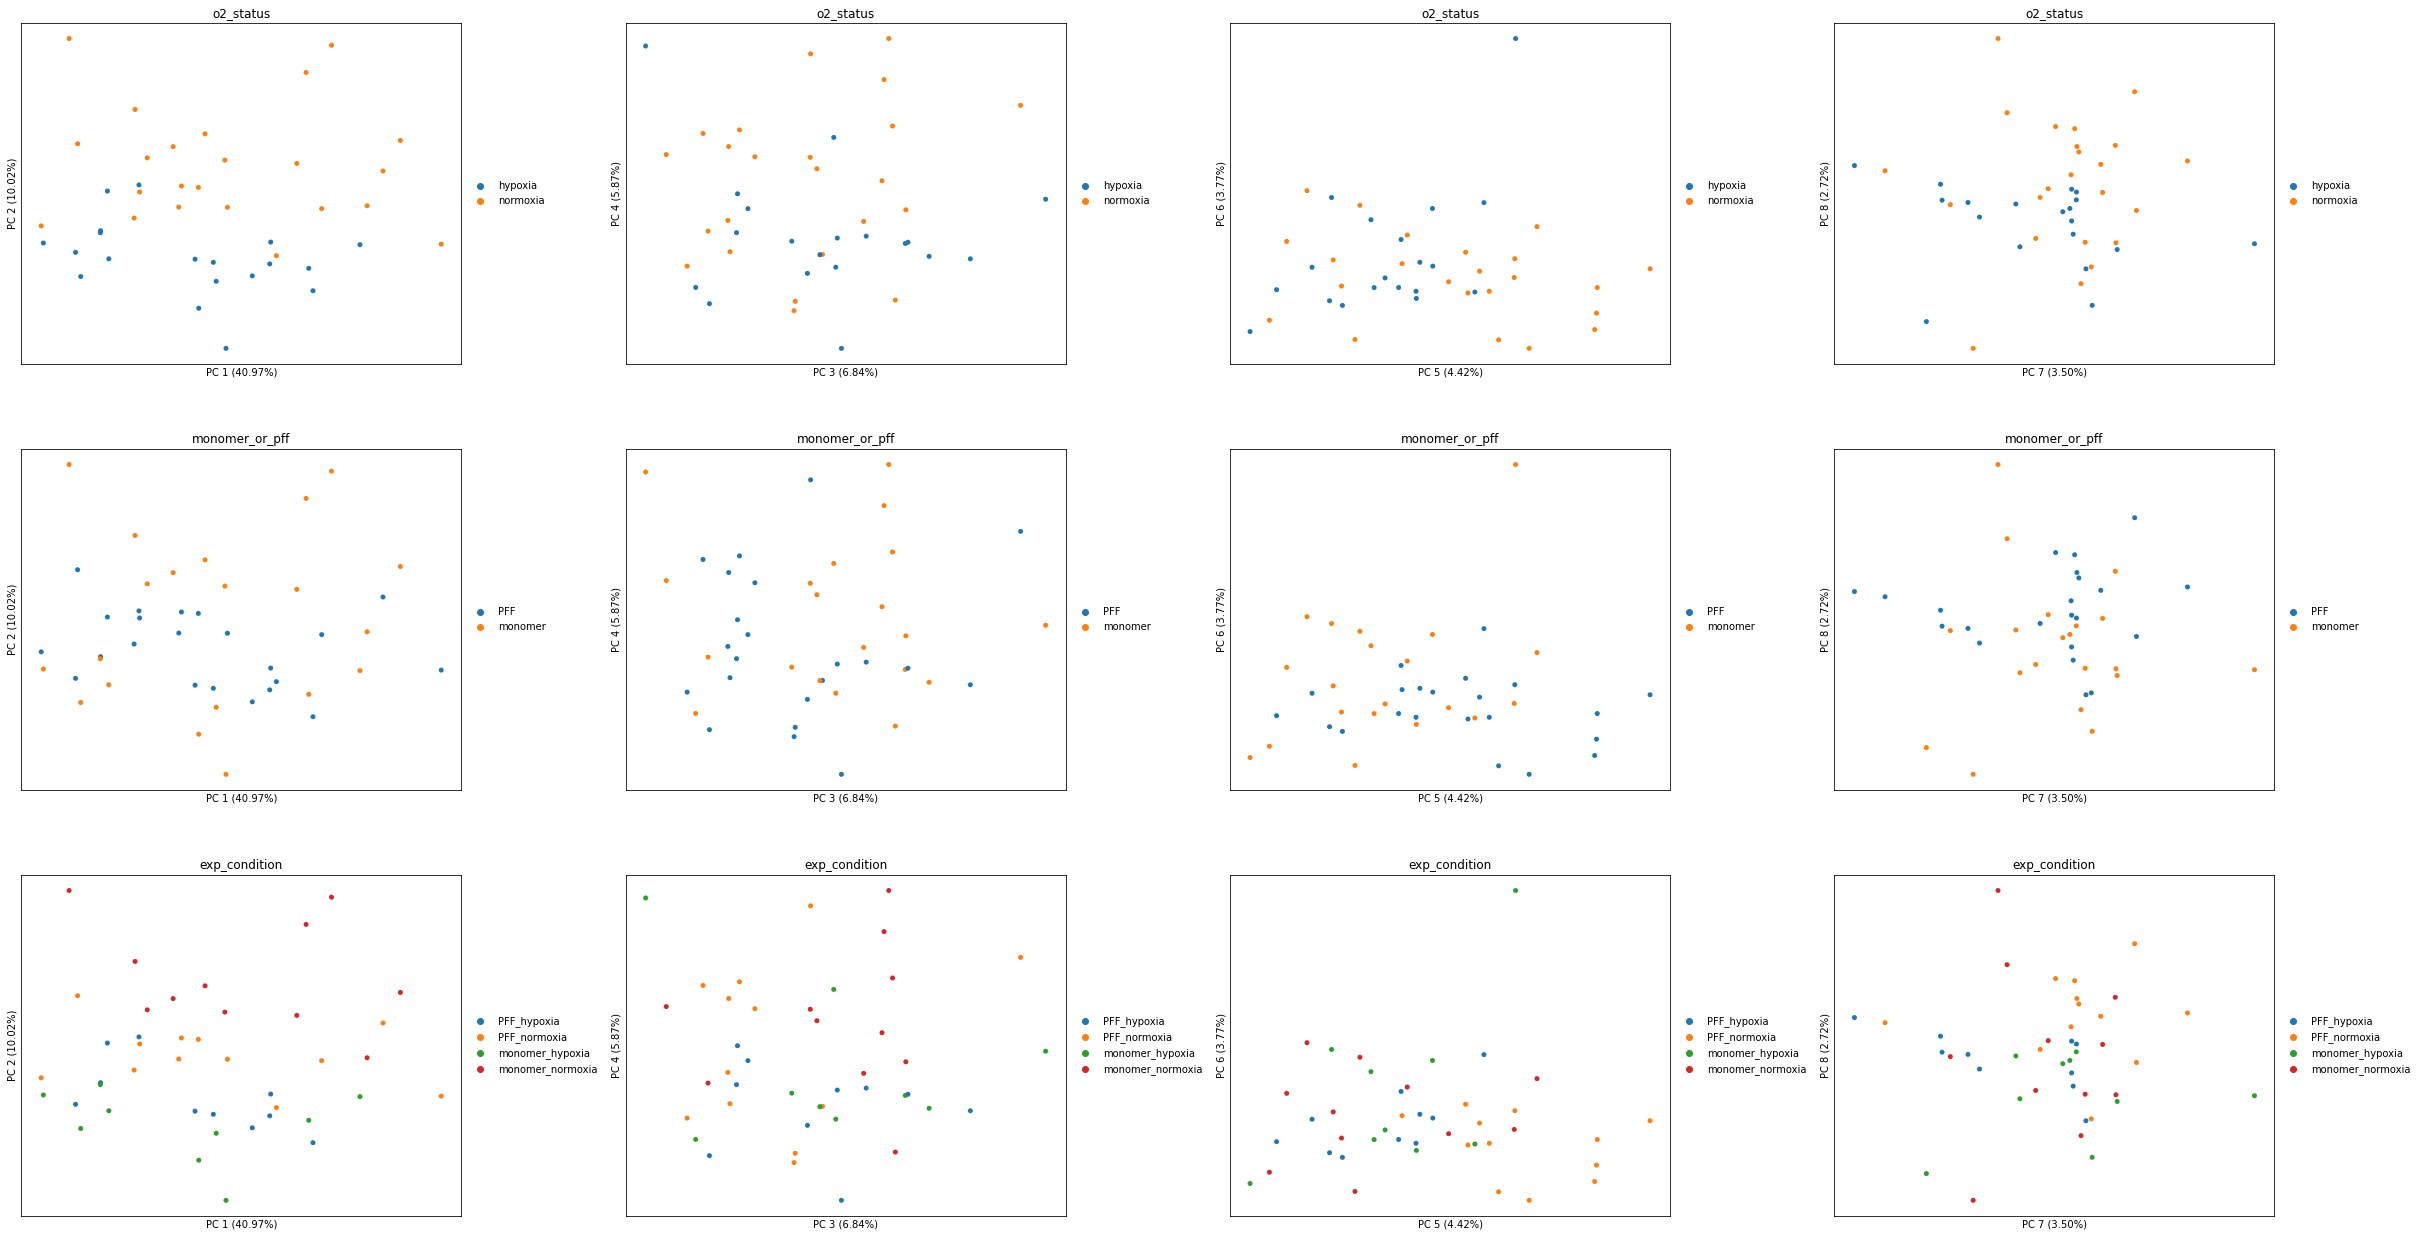

In [49]:
ncols=4
nrows=3
pyplot.rcParams.update({'font.size': 10})
with matplotlib.rc_context({'figure.figsize':(2*ncols, 2.2*nrows)}):
    fig = sc.pl.pca(anndata_obj, color=['o2_status', 'monomer_or_pff', 'exp_condition'], 
                    s=100, components=['1,2','3,4','5,6','7,8'], wspace=0.25, ncols=ncols, return_fig=True)
    for ax in fig.axes:
        #the colorbar axes are labeled with '<colorbar>' text, but data axes are not
        if ax.get_label():
            continue
        x_pc = int(ax.get_xlabel()[-1]) - 1
        ax.set_xlabel('PC {!s} ({:.2f}%)'.format(x_pc+1, anndata_obj.uns['pca']['variance_ratio'][x_pc] * 100))
    
        y_pc = int(ax.get_ylabel()[-1]) - 1
        ax.set_ylabel('PC {!s} ({:.2f}%)'.format(y_pc+1, anndata_obj.uns['pca']['variance_ratio'][y_pc] * 100))

    fig.show()

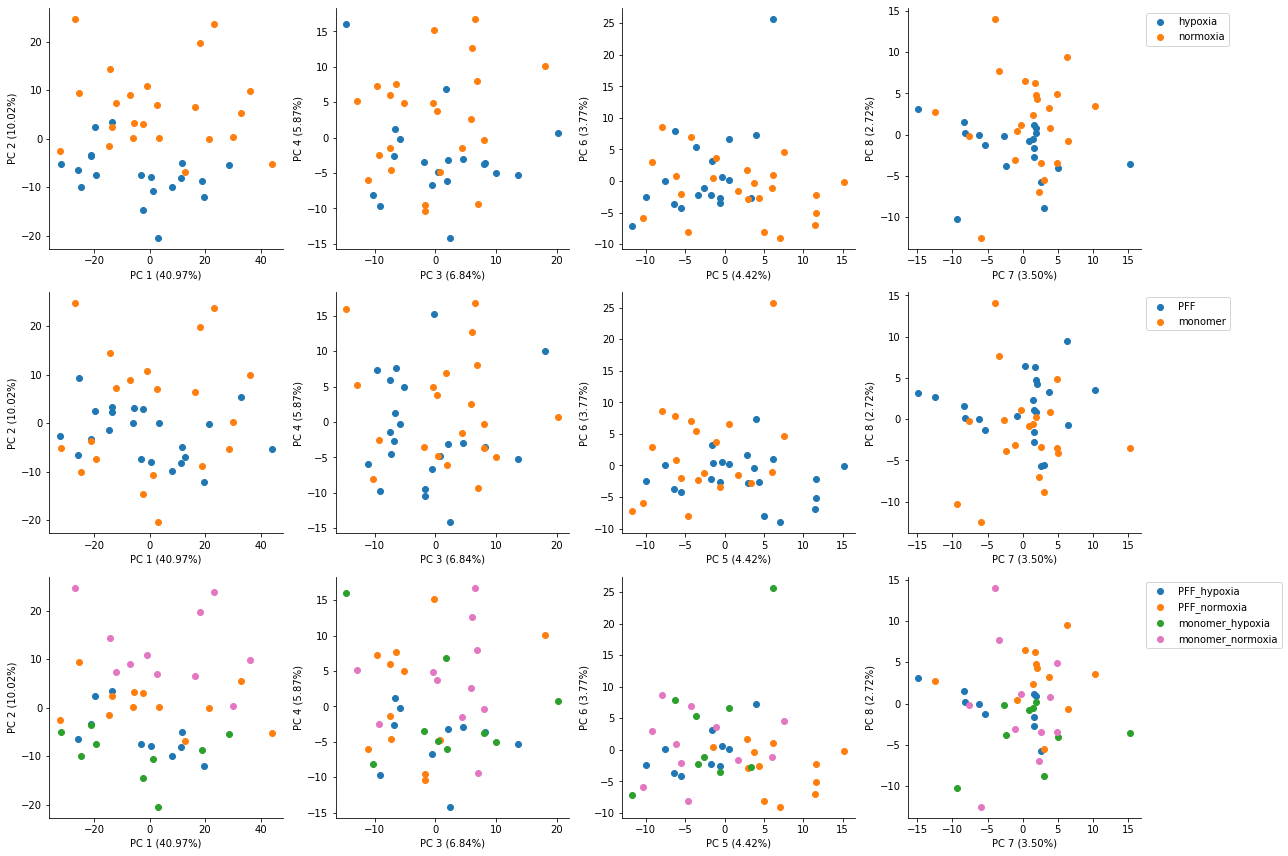

In [50]:
ncols=4
nrows=3
color_list = ['o2_status', 'monomer_or_pff', 'exp_condition']
fig, axes = pyplot.subplots(nrows=nrows, ncols=ncols, figsize=(4.5*ncols, 4*nrows))
for idx, (colorby, (pcx, pcy)) in enumerate(itertools.product(color_list, [(0,1), (2,3), (4,5), (6,7)])):
    ax_idx = (idx//ncols, idx%ncols)
    ax = axes[ax_idx]
    colorby = color_list[ax_idx[0]]
    unique_vals = sorted(anndata_obj.obs[colorby].unique())
    for color_idx, val in enumerate(unique_vals):
        val_idx = anndata_obj.obs[colorby] == val
        ax.scatter(anndata_obj[val_idx].obsm['X_pca'][:,pcx], anndata_obj[val_idx].obsm['X_pca'][:,pcy], 
                   c=f'C{color_idx if color_idx < 3 else color_idx+3}', label=val)
    ax.set_xlabel('PC {!s} ({:.2f}%)'.format(pcx+1, anndata_obj.uns['pca']['variance_ratio'][pcx] * 100))
    ax.set_ylabel('PC {!s} ({:.2f}%)'.format(pcy+1, anndata_obj.uns['pca']['variance_ratio'][pcy] * 100))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if ax_idx[1] == 3:
        ax.legend(bbox_to_anchor=[1,1], loc='upper left')

fig.tight_layout()

In [51]:
anndata_obj.write_h5ad('./anndata_obj.protein_coding.h5ad')